# Soils Revealed precalculations with `Zarrs`

<a id='libraries'></a>
### Python libraries

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask.array as da
from dask.diagnostics import ProgressBar, Profiler, ResourceProfiler, CacheProfiler, visualize
from xhistogram.xarray import histogram
import zarr
import rioxarray
import regionmask
import gcsfs
from geocube.api.core import make_geocube
import shapely.wkb 
import json
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from tqdm import tqdm

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()
from pathlib import Path 
env_path = Path('.') / '.env'

In [ ]:
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.  Launch dashboard
client

<a id='utils'></a>
### Utils

**show_xarray**

In [ ]:
def show_xarray(xds, colors=None, quantities=None):
    fig, ax = plt.subplots(figsize=(16,8.5))
    
    if colors and quantities:
        # Define the colors you want
        cmap = mpl.colors.ListedColormap(colors)
        # Define a normalization from values -> colors
        norm = mpl.colors.BoundaryNorm(quantities, len(colors))
        
        xds.plot(ax=ax, cmap=cmap, norm=norm)
    else:
        xds.plot(ax=ax)

<a id='df_from_carto'></a>
**df_from_carto**

In [ ]:
def df_from_carto(account, query):
    """
    It gets data by querying a carto table and converts it into a GeoDataFrame.
    """
    urlCarto = f"https://{account}.carto.com/api/v2/sql"
    
    sql = {"q": query}
    r = requests.get(urlCarto, params=sql)
    
    data = r.json()
    
    df = gpd.GeoDataFrame(data.get("rows"))
    if 'the_geom' in df.columns:
        # Change geometry from WKB to WKT format
        df['geometry'] = df.apply(lambda x: shapely.wkb.loads(x['the_geom'],hex=True), axis=1 )
        df.drop(columns=['the_geom'], inplace=True)
        if 'the_geom_webmercator' in df.columns:
            df.drop(columns=['the_geom_webmercator'], inplace=True)
        df.crs = {'init': 'epsg:4326'}
        df = df.to_crs({'init': 'epsg:4326'})
        
    return df

**set_lat_lon_attrs**

In [ ]:
def set_lat_lon_attrs(ds):
    """ Set CF latitude and longitude attributes"""
    ds["lon"] = ds.lon.assign_attrs({
      'axis' : 'X',
       'long_name' : 'longitude',
        'standard_name' : 'longitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_east',
            'valid_max' : 360.0,
             'valid_min' : -180.0
             })
    ds["lat"] = ds.lat.assign_attrs({
      'axis' : 'Y',
       'long_name' : 'latitude',
        'standard_name' : 'latitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_north',
            'valid_max' : 90.0,
             'valid_min' : -90.0
             })
    return ds

**create_ds_mask**

In [ ]:
def create_ds_mask(df, ds, id_prop, name_prop, name, debug=False):
  
    # Get mean ds cell area (in degrees) 
    mean_y_size = np.diff(ds.lat.values).mean()
    #print(mean_y_size)
    mean_x_size = np.diff(ds.lat.values).mean()
    #print(mean_x_size)
    mean_area = mean_y_size * mean_x_size
    print(f"The mean ds cell area is {np.round(mean_area, 6)} deg.\n")
    
    # Clip gdf to bounding box of ds
    xmin = ds.lon.min().values.tolist()
    xmax = ds.lon.max().values.tolist()
    ymin = ds.lat.min().values.tolist()
    ymax = ds.lat.max().values.tolist()
    df = df.cx[xmin:xmax, ymin:ymax]
    
    
    # Add area of geoms to gdf
    df = df.assign(area = df.area)
    df = df.assign(area_is_gt_cell = df['area'] > mean_area)
    print(f"Clipped gdf to dataset bounds, giving {len(df[id_prop])} potential geometries, of which {df['area_is_gt_cell'].sum()} are large enough.\n")
    
    print("Geometries smaller than mean cell size:")
    print(df.loc[df['area_is_gt_cell'] == False, [id_prop, name_prop]])
    print("\n")

    # Extract geoms, codes, names, and create code_ints that are large enough!
    id_names = df.loc[df['area_is_gt_cell'] == True, name_prop].values
    if debug:
        print("\n NAMEs for mask:\n")
        print(len(id_names))
        print(id_names)
    id_codes = df.loc[df['area_is_gt_cell'] == True, id_prop].values
    if debug:
        print("\n CODEs for mask:\n")
        print(len(id_codes))
        print(id_codes)
    geoms = df.loc[df['area_is_gt_cell'] == True, 'geometry'].values
    id_ints = list(range(0, len(id_codes)))
    if debug:
        print("\n IDs for mask:\n")
        print(len(id_ints))
        print(id_ints)

    # create mask object
    da_mask = regionmask.Regions(
      name = name,
      numbers = id_ints,
      names = id_names,
      abbrevs = id_codes,
      outlines = geoms)\
      .mask(ds)\
      .rename(name)
    if debug:
        print(da_mask)

    # get the ints actually written to mask
    id_ints_mask = da_mask.to_dataframe().dropna()[name].unique()
    id_ints_mask = np.sort(id_ints_mask).astype('int')
    if debug:
        print("\n Actually IDs on mask:\n")
        print(len(id_ints_mask))
        print(id_ints_mask)
    
    # resample the ints, names and codes
    id_names_mask = id_names[id_ints_mask]
    if debug:
        print("\n Actually NAMES on mask:\n")
        print(len(id_names_mask))
        print(id_names_mask)
    id_codes_mask = id_codes[id_ints_mask]
    if debug:
        print("\n Actually CODES on mask:\n")
        print(len(id_codes_mask))
        print(id_codes_mask)
    print(f"Finished writing {len(id_codes_mask)} geometries to {name} mask.\n")
    
    # update da attributes
    da_mask.attrs['id_ints'] = id_ints_mask
    da_mask.attrs['id_codes'] = id_codes_mask  
    da_mask.attrs['id_names'] = id_names_mask
    da_mask = set_lat_lon_attrs(da_mask)
    return da_mask

## Read `xarray.Dataset` from `Zarr` in Google cloud storage

In [31]:
%%time
# Connect to GS
project_name = 'soc-platform'
bucket_name = 'vizz-data-transfer'
root = bucket_name+'/SOC_maps/soil-data.zarr'
group = 'experimental-dataset-stock'
private_key = json.loads(os.getenv("PRIVATE_KEY"))

gc = gcsfs.GCSFileSystem(project=project_name, token=private_key)
store = gc.get_mapper(root)

# Return zarr group
xds = xr.open_zarr(store=store, group=group, consolidated=True)

# Change coordinates names
xds = xds.rename({'x': 'lon', 'y': 'lat'})

# Change depth coord from 0 to 1 dimensional array
depths = xds.coords.get('depth').values
if depths.ndim == 0: 
    xds = xds.squeeze().drop("depth")
    xds = xds.assign_coords({"depth": np.array([depths])})

xds = xds.isel(time=[0,18,35])
xds

CPU times: user 189 ms, sys: 29.4 ms, total: 218 ms
Wall time: 2.57 s


,Array,Chunk
Bytes,1.64 GB,2.14 MB
Shape,"(3, 13883, 9872)","(1, 868, 617)"
Count,6913 Tasks,768 Chunks
Type,float32,numpy.ndarray


In [ ]:
%%time
colors = ["#E18D67", "#CB5A3A", "#9D4028", "#6D2410", "#380E03"]
quantities = [0, 10, 40, 80, 200, 400]
show_xarray(xds['stocks'][0,2,2000:8000,2000:8000], colors, quantities)

## Read vector data
**Political boundaries**

In [ ]:
account = "wri-01"
query = "SELECT name_0, name_1, gid_0, gid_1, the_geom FROM gadm36_political_boundaries WHERE level = 1 and gid_0 = 'ARG'"

df = df_from_carto(account, query)

df = df.iloc[10:12]
#df['geometry'] = df['geometry'].apply(lambda x: x.simplify(0.05))

fig, ax = plt.subplots(figsize=(16,8.5))
df.plot(ax=ax)

**Create the data mask by rasterizing the vector data**

## Zonal statistics

**Create the data mask by rasterizing the vector data**

In [10]:
%%time
name = 'Argentina'
name_prop = 'name_1'
id_prop = 'gid_1'

da_mask = create_ds_mask(df, xds, id_prop, name_prop, name, debug=False)
da_mask

The mean ds cell area is 6e-06 deg.

Clipped gdf to dataset bounds, giving 2 potential geometries, of which 2 are large enough.

Geometries smaller than mean cell size:
Empty GeoDataFrame
Columns: [gid_1, name_1]
Index: []


Finished writing 2 geometries to Argentina mask.

CPU times: user 6.23 s, sys: 7.03 s, total: 13.3 s
Wall time: 16.9 s


<xarray.DataArray 'Argentina' (lat: 13883, lon: 9872)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -21.79 -21.79 -21.79 -21.79 ... -55.05 -55.05 -55.06
  * lon      (lon) float64 -74.7 -74.7 -74.7 -74.7 ... -51.05 -51.05 -51.05
Attributes:
    id_ints:   [0 1]
    id_codes:  ['ARG.7_1' 'ARG.6_1']
    id_names:  ['Corrientes' 'Córdoba']

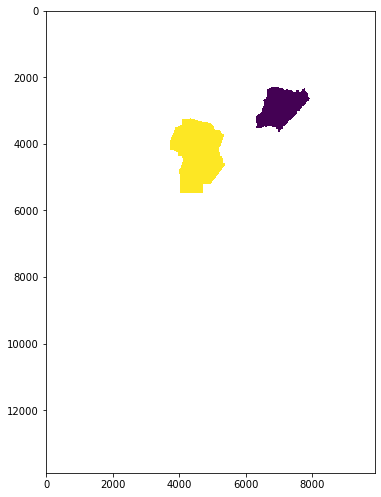

In [11]:
fig, ax = plt.subplots(figsize=(16,8.5))
ax.imshow(da_mask.values)

**Create a `xarray.Dataset` by merging both `xarray.Datasets`**

In [32]:
xds["index"] = da_mask
xds

,Array,Chunk
Bytes,1.64 GB,2.14 MB
Shape,"(3, 13883, 9872)","(1, 868, 617)"
Count,6913 Tasks,768 Chunks
Type,float32,numpy.ndarray


### Histogram
#### **Example**

In [33]:
indexes = xds.index.attrs.get('id_ints').astype(np.float32)
times = xds.coords.get('time').values
depths = xds.coords.get('depth').values

In [34]:
xds_index = xds.where(xds['index'].isin(indexes[0]))
diff = xds_index.loc[dict(time=times[2], depth=depths[0])] - xds_index.loc[dict(time=times[0], depth=depths[0])]
diff

<xarray.Dataset>
Dimensions:  (lat: 13883, lon: 9872)
Coordinates:
  * lon      (lon) float64 -74.7 -74.7 -74.7 -74.7 ... -51.05 -51.05 -51.05
  * lat      (lat) float64 -21.79 -21.79 -21.79 -21.79 ... -55.05 -55.05 -55.06
    depth    <U4 '0-30'
Data variables:
    stocks   (lat, lon) float32 dask.array<chunksize=(868, 617), meta=np.ndarray>
    index    (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

**with `xhistogram`**

In [35]:
bins = np.linspace(-50, 50, 41)
h = histogram(diff.stocks, bins=[bins], dim=['lat', 'lon'])
h

<xarray.DataArray 'histogram_stocks' (stocks_bin: 40)>
dask.array<getitem, shape=(40,), dtype=int64, chunksize=(40,), chunktype=numpy.ndarray>
Coordinates:
  * stocks_bin  (stocks_bin) float64 -48.75 -46.25 -43.75 ... 43.75 46.25 48.75

In [36]:
%%time
h.plot()

KeyboardInterrupt: 

Plot change distribution

In [ ]:
count = h.values
x_min = np.linspace(-50, 50, 40)
width = x_min[1]-x_min[0]
width -= width/4.
x_min -= width/4.

In [ ]:
per = count/count.sum()*100

plt.figure(figsize=(10,5))

plt.bar(x_min, per, width=width)

plt.plot([0,0], [0,per.max()], color = 'k', linestyle = '--')

plt.title('Soil Organic Carbon Stock')
plt.xlabel('SOC stock t C/ha)')
plt.ylabel('(%) of total area')

**with `da.histogram`**

In [23]:
h, bins = da.histogram(diff.stocks, bins=40, range=[-50, 50])

TypeError: <class 'xarray.core.dataarray.DataArray'>

In [ ]:
count = h.compute()

**Plot change distribution**

In [ ]:
x_min = bins[:-1]
width = x_min[1]-x_min[0]

In [ ]:
per = count/count.sum()*100

plt.figure(figsize=(10,5))

plt.bar(x_min, per, width=width)

plt.plot([0,0], [0,per.max()], color = 'k', linestyle = '--')

plt.title('Soil Organic Carbon Stock')
plt.xlabel('SOC stock t C/ha)')
plt.ylabel('(%) of total area')

**Display change value**

In [ ]:
years = pd.to_datetime(times[2]).year - pd.to_datetime(times[0]).year
mean_diff = diff.stocks.mean(skipna=True).compute().values
change = mean_diff/years

In [ ]:
print(f'Soil Organic Carbon Stock Change: {change} t C/ha year')

#### **All together**

In [37]:
def precalculate_change(df, xds, nBinds=40, bindsRange=[-50, 50]):
    indexes = xds.index.attrs.get('id_ints').astype(np.float32)
    times = xds.coords.get('time').values
    depths = xds.coords.get('depth').values
    
    Indexes = []
    Counts = []
    Bins = []
    Change = []
    Depth = []
    Dates = []
    
    for index in tqdm(indexes):
        xds_index = xds.where(xds['index'].isin(index))
        for depth in depths:
            for i in range(len(times)):
                for j in range(len(times)-1-i):
                    start_date = times[i]
                    end_date = times[i+j+1]
                    
                    # Get difference between two dates
                    diff = xds_index.loc[dict(time=end_date, depth=depth)] - xds_index.loc[dict(time=start_date, depth=depth)]
                    
                    # Get counts and binds of the histogram
                    h, bins = da.histogram(diff.stocks, bins=nBinds, range=bindsRange)
                    
                    # Compute change value
                    start_year = pd.to_datetime(start_date).year
                    end_year = pd.to_datetime(end_date).year
                    dYears = end_year - start_year
                    mean_diff = diff.stocks.mean(skipna=True).compute().values
                    change = mean_diff/dYears
                    
                    # Save values
                    Indexes.append(int(index))
                    Counts.append(h.compute())
                    Bins.append(bins)
                    Change.append(change)
                    Depth.append(depth)
                    Dates.append([start_year, end_year])

    return pd.merge(df.drop(columns='geometry').reset_index(drop=True).reset_index(), 
                    df_change, 
                    how='left', 
                    on='index').drop(columns=['index'])

In [38]:
%%time
result = precalculate_change(df, xds, nBinds=40, bindsRange=[-50, 50])



  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [08:50<08:50, 530.55s/it]

100%|██████████| 2/2 [15:15<00:00, 457.98s/it]


CPU times: user 2min 23s, sys: 28.6 s, total: 2min 51s
Wall time: 15min 16s


### Mean value
**Example**

In [ ]:
grouped_xds = xds.groupby(xds.index)
grid_mean = grouped_xds.mean().rename({"stocks": "mean"})
grid_mean.to_dataframe()